In [2]:
import pandas as pd

df = pd.read_csv('data/seniority-level-english.csv')

In [3]:
df.dropna(axis=0, inplace=True)

In [4]:
df.head()

,jobtitle,link,summary,description,seniority_level
0,Administrative Assistant,https://www.roberthalf.com/job/cincinnati-oh/a...,"Mail merging, pivot tables, and presentation d...","Mail merging, pivot tables, and presentation d...",Junior
1,Receptionist,https://www.roberthalf.com/job/charleston-sc/r...,OfficeTeam currently has a short-term temporar...,OfficeTeam currently has a short-term temporar...,Junior
2,Accounts Receivable Clerk,https://www.roberthalf.com/job/fresno-ca/accou...,If you're a self-starting and detail-oriented ...,If you're a self-starting and detail-oriented ...,Medior
3,Tax Staff - Public,https://www.roberthalf.com/job/dallas-tx/tax-s...,A multi-billion dollar company is looking for ...,A multi-billion dollar company is looking for ...,Medior
4,Customer Service Representative,https://www.roberthalf.com/job/palmer-ma/custo...,Seeking Customer Service Representatives! Off...,Seeking Customer Service Representatives!\n\nO...,Medior


In [5]:
df.shape

(607, 5)

In [6]:
df_jf = pd.read_csv('data/seniority-level-english-jf.csv')

In [7]:
df_jf.dropna(axis=0, inplace=True)

In [8]:
df_jf.head()

,Jobtitle,Vacancy,Seniority
0,dns web security researcher,Job Details Senior DNS/Web Security Researcher...,Senior
1,cook food nutrition,Cook - Food and Nutrition at White Plains Hosp...,Junior
2,digital integrated circuit design engineer,Senior Digital IC Design Engineer at Maxim Int...,Senior
3,application architect mobile,Application Architect: Mobile at IBM Bluemix V...,Senior
4,associate director icahn school medicine talen...,"Associate Director, Icahn School of Medicine, ...",Senior


In [10]:
df_jf.shape

(19, 3)

In [5]:
df['description'][3]

'A multi-billion dollar company is looking for a Staff Tax Accountant for their growing tax team. The Staff Tax Accountant will be joining a growing team that is part of a growing company and under a management team that believes in growing their people! As a Staff Tax Accountant you will prepare and document tax provision calculations and disclosures, file extensions, assist with income tax audits and research technical tax issues. There will also be other ad hoc requirements of this job that will give you a chance to work outside of traditional tax. This firm has been recognized as one of the “Best Places to Work in DFW" by the Dallas Business Journal and more recently as a “Best Accounting Firms to Work For" in the nation by Accounting Today.\n\nFor confidential consideration, please e-mail your resume directly to Eric Ressler at [email\xa0protected]\nIf you would like to receive updates more frequently, send me a LinkedIn request. You can find me at: https://www.linkedin.com/in/eri

In [11]:
from gensim.parsing.preprocessing import preprocess_string, RE_TAGS, strip_punctuation, stem_text, \
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, strip_non_alphanum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from unicodedata import normalize

def my_remove_tags(s):
    return RE_TAGS.sub(" ", s)

my_filters = [
    lambda x: x.lower(), my_remove_tags, strip_punctuation, strip_non_alphanum,
    strip_multiple_whitespaces, remove_stopwords
]

def my_tokenizer(s):
    return preprocess_string(s, filters=my_filters)
    
vect = CountVectorizer(min_df=10, max_df=0.2, analyzer='word', tokenizer=my_tokenizer, ngram_range=(1,2))

le = LabelEncoder()

X = vect.fit_transform(df['description'].tolist() + df_jf['Vacancy'].tolist())
y = le.fit_transform(df['seniority_level'].tolist() + df_jf['Seniority'].tolist())

scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

#svd = TruncatedSVD(n_components=250)
#X_lsa = svd.fit_transform(X)

In [12]:
X.shape

(626, 1888)

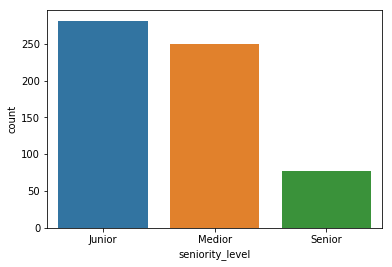

In [13]:
import seaborn as sns
%matplotlib inline

ax = sns.countplot(x=df['seniority_level'])

In [14]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC

classifiers = [
    MultinomialNB(),
    #LogisticRegression(solver='lbfgs', multi_class='multinomial'),
    LogisticRegression(solver='lbfgs', max_iter=250, multi_class='multinomial', class_weight='balanced'),
    #LinearSVC(),
    SVC(kernel='linear', probability=True),
    #KNeighborsClassifier(),
    RandomForestClassifier(n_estimators=25, min_samples_split=10),
    MLPClassifier(hidden_layer_sizes=(8,), max_iter=500),
]

classifiers[-1]._use_scaling = True

for clf in classifiers:
    accs = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='accuracy')
    f1s = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='f1_macro')
    lls = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='neg_log_loss')

    print("{:>24} Accuracy: {:.2f} (+/- {:.2f}) F1: {:.2f} (+/- {:.2f}) Log loss: {:.2f} (+/- {:.2f})" \
          .format(clf.__class__.__name__, accs.mean(), accs.std(), f1s.mean(), f1s.std(), lls.mean(), lls.std()))

           MultinomialNB Accuracy: 0.53 (+/- 0.02) F1: 0.50 (+/- 0.04) Log loss: -8.03 (+/- 0.89)
      LogisticRegression Accuracy: 0.65 (+/- 0.01) F1: 0.61 (+/- 0.01) Log loss: -0.97 (+/- 0.02)
                     SVC Accuracy: 0.62 (+/- 0.01) F1: 0.64 (+/- 0.03) Log loss: -0.81 (+/- 0.01)
  RandomForestClassifier Accuracy: 0.65 (+/- 0.00) F1: 0.54 (+/- 0.05) Log loss: -0.79 (+/- 0.01)
           MLPClassifier Accuracy: 0.61 (+/- 0.02) F1: 0.56 (+/- 0.05) Log loss: -1.38 (+/- 0.24)


In [15]:
X.shape

(626, 1888)

In [16]:
y.shape

(626,)

In [21]:
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33, stratify=y)

#clf = MultinomialNB()
clf = LogisticRegression(solver='lbfgs', max_iter=250, multi_class='multinomial', class_weight='balanced')
#clf = SVC(kernel='linear', probability=True)
clf.fit(Xtr, ytr)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=250,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [22]:
Xtr.shape

(419, 1888)

In [23]:
Xte.shape

(207, 1888)

In [24]:
from sklearn.metrics import classification_report

ypred = clf.predict(Xte)

print(classification_report(yte, ypred, target_names=le.classes_))

              precision    recall  f1-score   support

      Junior       0.72      0.74      0.73        95
      Medior       0.65      0.65      0.65        84
      Senior       0.64      0.57      0.60        28

   micro avg       0.68      0.68      0.68       207
   macro avg       0.67      0.65      0.66       207
weighted avg       0.68      0.68      0.68       207



In [25]:
le.classes_

array(['Junior', 'Medior', 'Senior'], dtype='<U6')

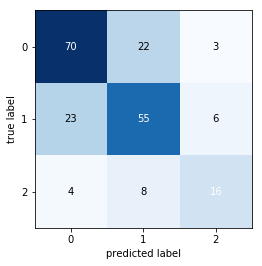

In [26]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(confusion_matrix(yte, ypred))

In [27]:
import numpy as np

feature_names = vect.get_feature_names()
for i, class_label in enumerate(le.classes_):
    top10 = np.argsort(clf.coef_[i])[-20:]
    print("%s: %s" % (class_label, ", ".join(feature_names[j] for j in top10)))
    print()

Junior: administrative tasks, package, technician, cash, experience customer, email resume, analyst, databases, level, intermediate, data entry, materials, directly email, background, entry level, 1 2, junior, 1 year, year, 1 years

Medior: workers, obtain, monthly, reputable, coordinating, independently, loans, experience working, work independently, corporate, reports, development, hardware, specialist, consideration send, california, video, 3 years, 3, 2 years

Senior: patient, ideal, highly preferred, metrics, law, leadership, general, engineer, support team, good, phone, account, senior, state, manage, manager, analysis, lead, 5 years, 5



In [26]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(config_dict='TPOT sparse', generations=30, population_size=10, verbosity=2,
                      scoring='neg_log_loss', cv=5, n_jobs=4)
tpot.fit(Xtr, ytr)
print(tpot.score(Xte, yte))

Generation 1 - Current best internal CV score: -0.7416689405850022
Generation 2 - Current best internal CV score: -0.7416689405850022
Generation 3 - Current best internal CV score: -0.7416689405850022
Generation 4 - Current best internal CV score: -0.7416689405850022
Generation 5 - Current best internal CV score: -0.7416689405850022
Generation 6 - Current best internal CV score: -0.7415928656683926
Generation 7 - Current best internal CV score: -0.7244327000259926
Generation 8 - Current best internal CV score: -0.7244327000259926
Generation 9 - Current best internal CV score: -0.7244327000259926
Generation 10 - Current best internal CV score: -0.7233350893815307
Generation 11 - Current best internal CV score: -0.7233350893815307
Generation 12 - Current best internal CV score: -0.7233350893815307
Generation 13 - Current best internal CV score: -0.7226786898270599
Generation 14 - Current best internal CV score: -0.7226786898270599
Generation 15 - Current best internal CV score: -0.716172